### Imports:

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable,Sequence

#### Integrating Function:

In [3]:
def gaussian(x: np.ndarray) -> np.ndarray:
    """
    the distribution function for generating random numbers
    sigma represent the thickness of the distribution
    x0 represents where the max of probabilities is

    :param x:the position
    :type x:np.ndarray
    :return:the probability of random number generation = x
    :rtype:np.ndarray
    """
    sigma = 1
    x0 = 0
    c = 1/ np.sqrt(2*np.pi*sigma**2)
    return c*np.exp(-(x-x0)**2 /(2*sigma**2))

### Classes:

In [4]:
class MetroPolice:
    acceptanceRates = np.arange(1,21)/20
    """
    the class to simulate the MetroPolice Algorithm
    Methods:
    step:
        the function to perform one step in metroPolice algorithm

    generate:
        the function to generate n random numbers with metrPolice algorithm

    tuneDelta:
        the function to tune the generator for the input acceptance rate with size n and in iteration

    getAutoCorrelation:
        the function to get AutoCorrelation for n random Numbers and targetJ(as the last j)

    getCorrelationLength;
        the function to get the correlation length from the autoCorrelation of the random numbers

    with thanks for Ali Mahani for some debugging hints!
    """
    def __init__(self, function: Callable, delta: float, x0: float) -> None:
        """
        the function to construct a rando mgenerator with metroPolice algorithm

        :param function: the distribution function
        :type function: Callable
        :param delta: the step of the metroPolice algorithm
        :type delta: float
        :param x0: the init position in metroPolice algorithm
        :type x0: float
        """
        self.function = function
        self.delta = delta
        self.x = x0
        self.acceptedSteps = 0

    def step(self) -> None:
        """
        the function to perform one step in metroPolice algorithm

        metroPolice algorithm:
        1- calculate y = x + random(-1,1)*delta
        2- if random(0,1) < f(y)/f(x) : x=y

        """
        y = float(self.x + self.delta * np.random.uniform(-1,1,1))
        if np.random.uniform(0,1,1) < (self.function(y)/self.function(self.x)):
            self.x = y
            self.acceptedSteps += 1

    def generate(self, n: int) -> Sequence:
        """
        the function to generate n random numbers with metrPolice algorithm

        :param n:the size of generated numbers
        :type n:int
        :return:the random numbers,acceptance rate
        :rtype:Sequence
        """
        self.acceptedSteps = 0
        xs = np.zeros(n)
        for i in range(n):
            self.step()
            xs[i] = self.x
        return xs,self.acceptedSteps/n

    def tuneDelta(self, requiredAcceptanceRate: float, n: int, iterations: int) -> None:
        """
        the function to tune the generator for the input acceptance rate with size n and in iteration

        1- for iteration,generate random numbers with size n and find the mean of acceptance rates
        2- if the mean Acceptance rate is equal to the input one:break
        3- if the mean Acceptance rate is less than the input one,decrease delta(it increases acceptance rate)
        4- if the mean Acceptance rate is more than the input one,increase delta(it decreases acceptance rate)
        5- repeat till break

        :param requiredAcceptanceRate:the input acceptance rate
        :type requiredAcceptanceRate:float
        :param n:the size of random numbers
        :type n:int
        :param iterations:the iteration of sampling
        :type iterations:int
        """
        while True:
            acceptanceRates = []
            for _ in range(iterations):
                acceptanceRates.append(self.generate(n)[1])

            meanAcceptanceRate = np.mean(acceptanceRates)

            if meanAcceptanceRate == requiredAcceptanceRate:
                break
            else:
                if meanAcceptanceRate < requiredAcceptanceRate:
                    self.delta *= 1 - (requiredAcceptanceRate-meanAcceptanceRate)
                else: self.delta *= 1 + (meanAcceptanceRate-requiredAcceptanceRate)

    def getAutoCorrelation(self, n: int, targetJ: int) -> np.ndarray:
        """
        the function to get AutoCorrelation for n random Numbers and targetJ(as the last j)

        c(j) = (<x(i),x(i+j)> - <x(i)><x(i+j)> )/var(x)

        :param n:the size of random numbers
        :type n:int
        :param targetJ:the last j
        :type targetJ:int
        :return:the autoCorrelation array
        :rtype:np.ndarray
        """
        randomNumbers,_ = self.generate(n)
        autoCorrelation = np.zeros(targetJ)

        # calculating s = <x(i),x(i+j)>
        for j in range(0, targetJ):
            s = 0
            for k in range(n - j):
                s += randomNumbers[k] * randomNumbers[k + j]
            s /= n - j

            autoCorrelation[j] = (s - np.mean(randomNumbers) ** 2) / np.var(randomNumbers)
        return autoCorrelation

    @staticmethod
    def getCorrelationLength(autoCorrelation: np.ndarray) -> int:
        """
        the function to get the correlation length from the autoCorrelation of the random numbers
        we find the index that till that the autoCorrelation fits e^-1

        :param autoCorrelation:the autoCorrelation of the random numbers
        :type autoCorrelation:np.ndarray
        :return:the correlation length
        :rtype:int
        """
        return len(autoCorrelation[autoCorrelation > np.exp(-1)])

## part 1:

### Generating 100000 random number before and after tuning with 0.5 acceptance Rate:

In [5]:
metroPolice = MetroPolice(gaussian,10,0)

In [6]:
numbers,acceptanceRate = metroPolice.generate(100000)
print("acceptance rate is: ",acceptanceRate)

acceptance rate is:  0.16009


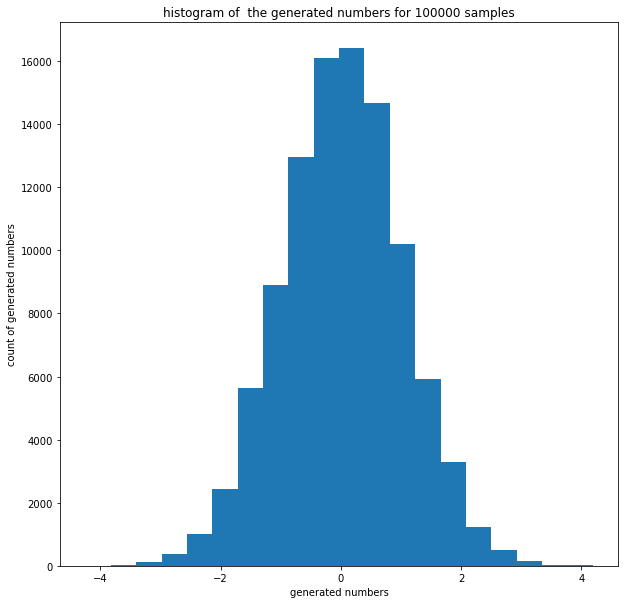

In [7]:
plt.figure(figsize=(10,10))
plt.title("histogram of  the generated numbers for 100000 samples")
plt.xlabel("generated numbers")
plt.ylabel("count of generated numbers")
plt.hist(numbers,bins=20)
plt.show()

In [8]:
#tuning with 0.5 acceptance rate with length 1000:
metroPolice.tuneDelta(0.5,1000,10)

In [9]:
numbers,acceptanceRate = metroPolice.generate(100000)
print("acceptance rate is: ",acceptanceRate)

acceptance rate is:  0.49667


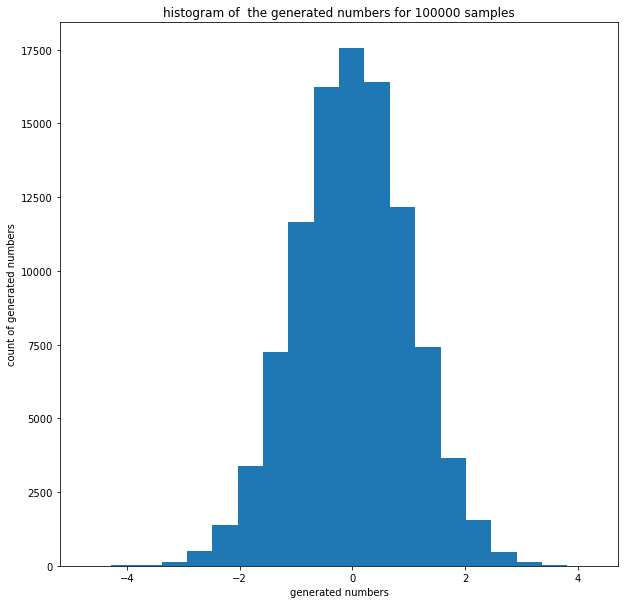

In [10]:
plt.figure(figsize=(10,10))
plt.title("histogram of  the generated numbers for 100000 samples")
plt.xlabel("generated numbers")
plt.ylabel("count of generated numbers")
plt.hist(numbers,bins=20)
plt.show()

## Part 2:

In [18]:
metroPolice = MetroPolice(gaussian,10,0)
correlationLengths = []
autoCorrelations = []

for i in MetroPolice.acceptanceRates:
    # repeating sampling for different acceptance rates
    correlationLengthsTries = []
    autoCorrelationTries = []
    # repeating sampling for 10 times and find the mean
    for _ in range(10):
        metroPolice.tuneDelta(i,1000,10)

        autoCorrelation = metroPolice.getAutoCorrelation(1000,50)
        correlationLength = metroPolice.getCorrelationLength(autoCorrelation)

        correlationLengthsTries.append(correlationLength)
        autoCorrelationTries.append(autoCorrelation)

    correlationLengths.append(np.mean(correlationLengthsTries))
    autoCorrelations.append(np.mean(autoCorrelationTries,axis=0))

## Plotting:

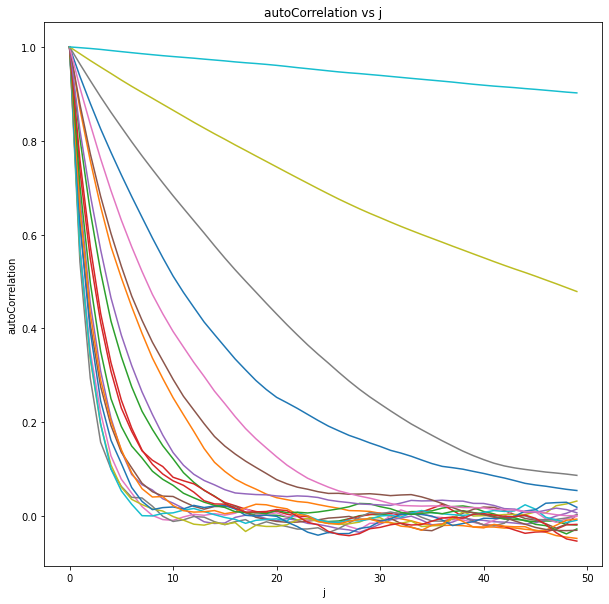

In [19]:
plt.figure(figsize=(10,10))
plt.title("autoCorrelation vs j")
plt.xlabel("j")
plt.ylabel("autoCorrelation")

for b in autoCorrelations:
    plt.plot(np.arange(len(b)),b)

plt.show()

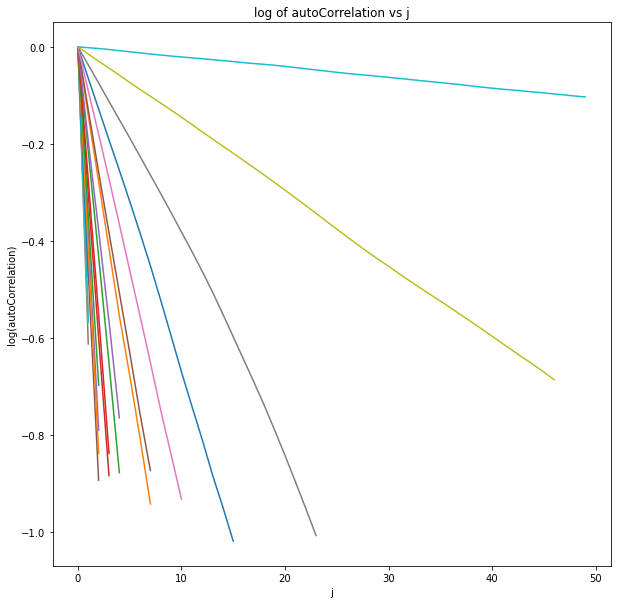

In [20]:
plt.figure(figsize=(10,10))
plt.title("log of autoCorrelation vs j")
plt.xlabel("j")
plt.ylabel("log(autoCorrelation)")

for i in range(len(autoCorrelations)):
    plt.plot(np.arange(int(correlationLengths[i])),np.log(autoCorrelations[i][:int(correlationLengths[i])]))

plt.show()

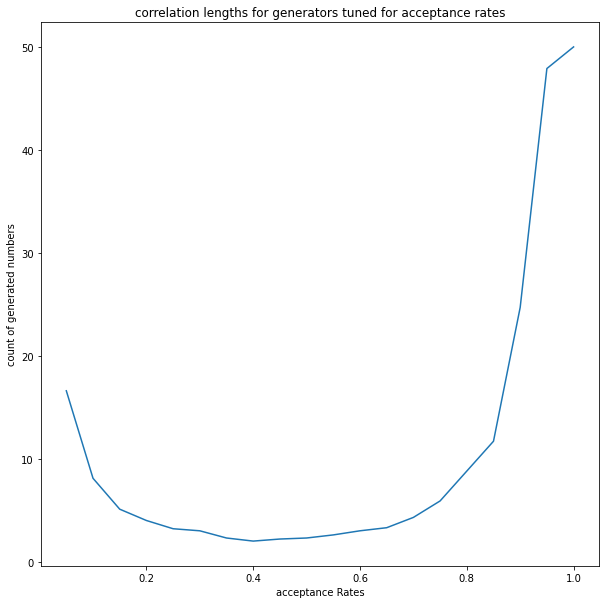

In [21]:
plt.figure(figsize=(10,10))
plt.title("correlation lengths for generators tuned for acceptance rates")
plt.xlabel("acceptance Rates")
plt.ylabel("count of generated numbers")
plt.plot(MetroPolice.acceptanceRates,correlationLengths)
plt.show()

## Part 3:

In [12]:
deltas = []

In [13]:
for i in MetroPolice.acceptanceRates:
    metroPolice = MetroPolice(gaussian, 1, 0)
    metroPolice.tuneDelta(i,1000,10)
    deltas.append(metroPolice.delta)

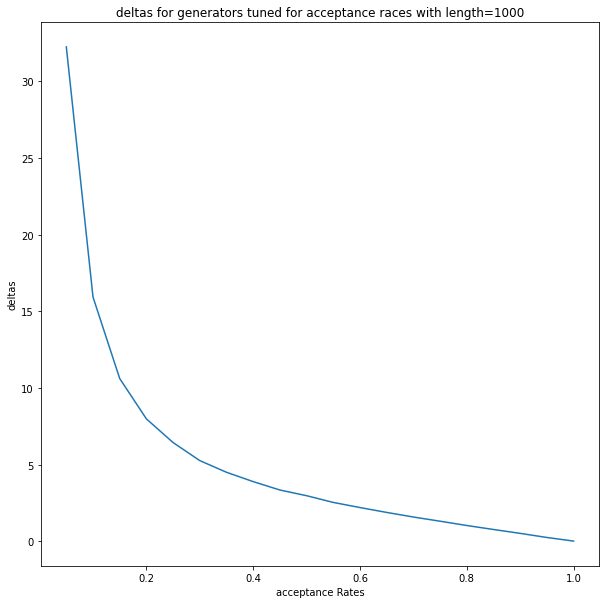

In [14]:
plt.figure(figsize=(10,10))
plt.title("deltas for generators tuned for acceptance races with length=1000")
plt.xlabel("acceptance Rates")
plt.ylabel("deltas")
plt.plot(MetroPolice.acceptanceRates,deltas)
plt.show()